# Plot IBD between two Sites

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import h5py
import matplotlib.cm as cm
import itertools as it
import multiprocessing as mp
import itertools as it

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/ibd_euro/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")


os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

from TTNe.analytic import singlePop_2tp_given_Ne_negLoglik
from TTNe.analytic_multi import inferConstNe_singlePop_MultiTP
from hapsburg.PackagesSupport.roh_expectations import Expected_Roh

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

compute-e-16-230.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/ibd_euro
CPU Count: 28


In [2]:
def get_ibd_sites(df_ibd=[],  df_meta=[], site1="", site2="", output=True):
    """Return all IBD shared between site1 and site2.
    Return IBD dataframe as well as number of matching IIDs in the two sites in df_meta"""
    # Default of empty site2 is site1
    if len(site2)==0:
        site2 = site1
    
    iids1 = df_meta[df_meta['iid'].str.startswith(site1)]['iid'].to_list()
    iids2 = df_meta[df_meta['iid'].str.startswith(site2)]['iid'].to_list()
    n1, n2 = len(iids1), len(iids2)
    if output:
        print(f'Number of {site1} samples: {n1}')
        if site2!=site1: # Only Plot if second site different
            print(f'Number of {site2} samples: {n2}')
    
    dft = get_ibd_iids(df_ibd, iids1, iids2) # Get matching IBD
    
    return dft, n1, n2

def get_ibd_iid_lists(df_ibd=[], iids1=[], iids2=[], output=True):
    """Return all IBD shared between list of iids1 and iids2.
    Return IBD dataframe as well as number of matching IIDs in the two sites in df_meta"""
    # Default of empty site2 is site1
    if len(iids2)==0:
        iids2 = iids1

    n1, n2 = len(iids1), len(iids2)
    if output:
        print(f'Number of sample 1: {n1}')
        if set(iids1)!=set(iids2):
            print(f'Number of sample 2: {n2}')
    
    dft = get_ibd_iids(df_ibd, iids1, iids2) # Get matching IBD
    return dft, n1, n2

def get_ibd_iids(df_ibd, iids1=[], iids2=[]):
    """Get subset of all IBDs between iids1 (list) and iids2 (list).
    Return sub dataframe of df_ibd"""
    # select rows whose iid1 column is in the list of ETA_iid and iid2 column is in the list of PHA_iid
    # or vice versa
    subset1 = df_ibd[df_ibd['iid1'].isin(iids1) & df_ibd['iid2'].isin(iids2)]
    subset2 = df_ibd[df_ibd['iid1'].isin(iids2) & df_ibd['iid2'].isin(iids1)]
    dft = pd.concat([subset1, subset2])
    dft = dft.drop_duplicates(keep="first") # Drop Duplicate Entries. To deal with overlapping iids
    return dft

def find_relatives(df, col_rel="sum_IBD>12", min_cm=200):
    """Return all pairs of related IIDs in IBD dataframe df as well as nr of relatives"""
    nrelatives = np.sum(df[col_rel] > min_cm)
    print(f'Number of relatives: {nrelatives}')
    
    relatives = [[row['iid1'], row['iid2']] for index, row in df.iterrows() if row[col_rel] > min_cm]
    return nrelatives, relatives

def filter_ibd(df, relatives=[]):
    """Filter IBD df for all pairs in pairs (list of 2 Element lists)"""
    for relative in relatives:
        df = df[~((df['iid1'] == relative[0]) & (df['iid2'] == relative[1]))]
        df = df[~((df['iid1'] == relative[1]) & (df['iid2'] == relative[0]))]
    return df

def get_ibd_stats_unrelated(df_ibd_ind, df_ibd, df_meta, site1="", site2="", 
                            iids1=[], iids2=[], col_rel="sum_IBD>12", min_cm=100, output=True):
    """Get IBD dataframe and number tested between site1 and site2
    If needed, filter close relatives based on relative column
    Return IBD dataframe and pair number.
    If iids1 given, use list of Individual IIDs (and not site values)
    df_meta: Meta file of every indivdiual ran for IBD
    df_ibd: File of all IBD segments
    df_ibd_ind: File of all IBD summary stats per pair"""
    
    if len(iids1)==0: 
        dft, n1, n2 = get_ibd_sites(df_ibd, df_meta, site1=site1, site2=site2)
        dft_ind, _, _ = get_ibd_sites(df_ibd_ind, df_meta, site1=site1, site2=site2, output=False)
        
    else:
        dft, n1, n2 = get_ibd_iid_lists(df_ibd, iids1=iids1, iids2=iids2)
        dft_ind, _, _ = get_ibd_iid_lists(df_ibd_ind, iids1=iids1, iids2=iids2, output=False)
        
    
    if (site1==site2) or (len(site2)==0):
        n_pairs = int(n1 * (n1-1) / 2) # int just for printing below
    else:
        n_pairs = int(n1 * n2)
        
    nrelatives, relatives = find_relatives(dft_ind)
    dft=filter_ibd(dft, relatives) # Filter out the relative pairs
    n_pairs1 = n_pairs - nrelatives # Substract related indvidiuals
    print(f"Filtered to {n_pairs1}/{n_pairs} non-related iids ({col_rel}<{min_cm})")
    
    return dft, n_pairs1

def plot_ibd_2sites(df_ibd, df_ibd_ind, df_meta,
    site1="", site2="", iids1=[], iids2=[],
    figsize = (6,6), bins = np.arange(8, 30, 1),
    Ne_plot = [4000, 35000], # Diploid Pop Size
    c_Ne = "gray", alpha=0.6,
    yscale="log", savepath=""):
    """Plot IBD across two sites together with predictions"""
    
    ### Extract the IBD segments within and between each site
    df_ibd1, npairs_1 = get_ibd_stats_unrelated(df_ibd_ind, df_ibd, df_meta, site1=site1, site2=site1, iids1=iids1, iids2=iids1)
    df_ibd2, npairs_2 = get_ibd_stats_unrelated(df_ibd_ind, df_ibd, df_meta, site1=site2, site2=site2, iids1=iids2, iids2=iids2)
    df_ibda, npairs_across = get_ibd_stats_unrelated(df_ibd_ind, df_ibd, df_meta, site1=site1, site2=site2, iids1=iids1, iids2=iids2, output=False)

    ### The figure
    plt.figure(figsize=figsize)
    ax=plt.gca()

    ax.hist(100*df_ibd1['lengthM'], bins=bins, alpha=alpha, label=site1, ec="gray", color="blue",
             weights=np.ones(len(df_ibd1))/npairs_1)
    ax.hist(100*df_ibd2['lengthM'], bins=bins, alpha=alpha, label=site2, ec="gray", color="violet",
             weights=np.ones(len(df_ibd2))/npairs_2)
    ax.hist(100*df_ibda['lengthM'], bins=bins, alpha=alpha, label='Between', ec="gray", color="lime",
                weights=np.ones(len(df_ibda))/npairs_across)

    ### Calculate and plot expected IBD
    e_roh = Expected_Roh()  
    binmidpoint = (bins[1:] + bins[:-1])/2
    binwidth = bins[1] - bins[0]
    for N in Ne_plot:
        y = e_roh.roh_pdf_allchr_N(binmidpoint/100, N=2*N )*4*binwidth/100
        ax.plot(binmidpoint, y, color=c_Ne, linestyle='dashed')
        ax.text(binmidpoint[0], y[0], f"Ne={N}", color='black', fontsize=12)

    ax.legend(loc='upper right', title="IBD Sharing")
    ax.set_xlabel('IBD segment length (cM)')
    ax.set_ylabel('Average # of IBD segments per pair')
    ax.set_yscale(yscale)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
        print(f"Saved to {savepath}")
    
    plt.show()
    
def plot_ibd_single_site(df_ibd, df_ibd_ind, df_meta,
    site="", iids=[], title="",
    figsize = (6,6),
    bins = np.arange(8, 30, 1), ax=0,
    Ne_plot = [4000, 35000], # Diploid Pop Size
    c_plot = ["#5ec962", "#440154"], alpha=0.6, c="sandybrown",
    legend = True, yscale="log", savepath="", show=True):
    """Plot IBD Histogram of a single site.
    iids: If given, use iid list directly instead of site"""
    if ax==0:
        plt.figure(figsize=figsize)
        ax=plt.gca()
        
    df_ibd, npairs = get_ibd_stats_unrelated(df_ibd_ind, df_ibd, df_meta, 
                                             site1=site, site2=site, iids1=iids, iids2=iids)
    
    
    ax.hist(100*df_ibd['lengthM'], bins=bins, alpha=alpha, label=site, ec="gray", color=c,
             weights=np.ones(len(df_ibd))/npairs)
    ax.axhline(1/npairs, linestyle="-", label="One segment", zorder=0, color="lightgray") # Horizontal Line
    
    ### Plot the Expected IBD
    e_roh = Expected_Roh()  
    binmidpoint = (bins[1:] + bins[:-1])/2
    binwidth = bins[1] - bins[0]
    for N, c in zip(Ne_plot, c_plot):
        y = e_roh.roh_pdf_allchr_N(binmidpoint/100, N=2*N )*4*binwidth/100
        ax.plot(binmidpoint, y, color=c, linestyle='dashed')
        ax.text(binmidpoint[0], y[0], f"Ne={N}", color='black', fontsize=12)
    
    if legend:
        ax.legend(loc='upper right', title="IBD Sharing")
        
    if title:
        ax.set_title(title)
        
    ax.set_xlabel('IBD segment length (cM)')
    ax.set_ylabel('Average # of IBD segments per pair')
    ax.set_yscale(yscale)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
        print(f"Saved to {savepath}")
    
    if show:
        plt.show()   
        
        
def fit_Ne_ibd(df, n_pairs, bins = np.arange(8, 30, 0.25), Ne_list = np.arange(100, 20000, 100)):
    """Fit Ne for IBD data frame using ML approach.
    Return Ne (maxL approach), lower CI, and upper CI (CIs based on maxLL - 1.92)
    df: IBD Dataframe of all IBD segments
    n_pairs: Number of Pairs (of IIDs)
    Ne_list: List of Ne values to try
    """
    binMidpoint = (bins[1:] + bins[:-1])/2
    histo, _ = np.histogram(100*df['lengthM'], bins=bins)
    
    ### Hard Coded Human Genome Parameters
    ch_len_dict = {1:286.279, 2:268.840, 3:223.361, 4:214.688, 5:204.089, 6:192.040, 7:187.221, 8:168.003, 9:166.359, \
        10:181.144, 11:158.219, 12:174.679, 13:125.706, 14:120.203, 15:141.860, 16:134.038, 17:128.491, 18:117.709, \
        19:107.734, 20:108.267, 21:62.786, 22:74.110}
    G = np.array([val for k, val in ch_len_dict.items()]) # Total Genom length

    mat = np.zeros(len(Ne_list))

    for i, Ne in enumerate(Ne_list):
        mat[i] = -singlePop_2tp_given_Ne_negLoglik(Ne, histo, binMidpoint, G, 0, 0, 4*n_pairs, [(0,0), (0,0)])

    maxll = np.max(mat)
    i1 = np.where(mat == maxll)
    i1 = i1[0][0]

    CIregionNe = np.where(mat >= maxll - 1.92)
    Ne_CI = Ne_list[CIregionNe]
    
    print(f'MLE Ne: {Ne_list[i1]} (95% CI: {np.min(Ne_CI)}-{np.max(Ne_CI)})')
    return Ne_list[i1], np.min(Ne_CI), np.max(Ne_CI)

In [10]:
### Full IBD data
version = "54.1b"
df_ibd_ind = pd.read_csv(f"/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ind.v{version}.tsv", sep='\t')
df_ibd = pd.read_csv(f"/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ibd.v{version}.tsv", sep='\t')
df_meta = pd.read_csv(f"/n/groups/reich/hringbauer/git/ibd_euro/data/iid_lists/iid_ibd_v{version}.tsv", sep="\t")

### Full Punic Data
df_p = pd.read_csv("/n/groups/reich/hringbauer/git/punic_aDNA/data/cluster_assignments_punic.v54.1j.tsv", sep="\t")
print(f"Loaded Punic Cluster Information for {len(df_clst)} Individuals.\n")

idx1 = df_p["labelPCA"]=="Punic_Early"
idx2 = df_p["labelPCA"]=="Punic_Late"
df_pp = df_p[idx1 | idx2]
print(f"Loaded {len(df_pp)} proper Punic Individuals.")

Loaded Punic Cluster Information for 160 Individuals.

Loaded 116 proper Punic Individuals.


### Plot Punic and IA Italy

In [20]:
label1 = "Italy_IA"
iids1 = df_meta[df_meta["clst"]==label1]["Master ID"].values

iids2 = df_pp["iid"].values

n1,n2 = len(iids1), len(iids2)
print(f"Found {n1} for {label1}.")
print(f"Found {n2} for Punic Proper.")

Found 150 for Italy_IA.
Found 116 for Punic Proper.


Number of sample 1: 150
Number of relatives: 30
Filtered to 11145/11175 non-related iids (sum_IBD>12<100)
Number of sample 1: 116
Number of relatives: 13
Filtered to 6657/6670 non-related iids (sum_IBD>12<100)
Number of sample 1: 150
Number of sample 2: 116
Number of relatives: 0
Filtered to 17400/17400 non-related iids (sum_IBD>12<100)


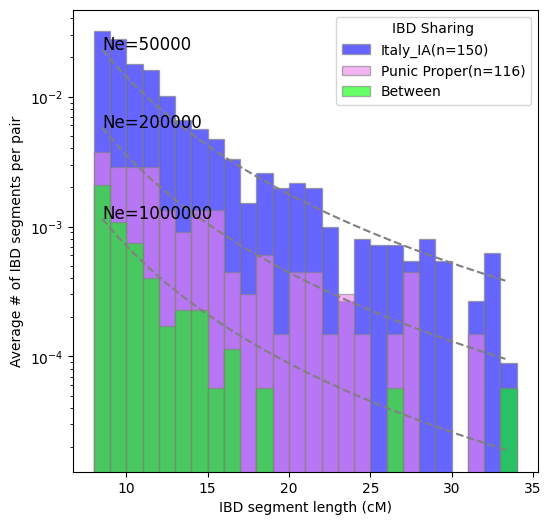

In [22]:
plot_ibd_2sites(
    df_ibd=df_ibd, df_ibd_ind=df_ibd_ind, df_meta=df_meta,
    iids1=iids1, iids2=iids2, site1=label1 + f"(n={n1})", site2="Punic Proper" + f"(n={n2})",
    figsize = (6,6),
    bins = np.arange(8, 35, 1),
    Ne_plot = [50000, 200000, 1000000], # Diploid Pop Size
    yscale="log",
    savepath = "")

### Plot Italy_MIA and Punic proper

Found 56 for Italy_MIA.
Found 116 for Punic Proper.
Number of sample 1: 56
Number of relatives: 9
Filtered to 1531/1540 non-related iids (sum_IBD>12<100)
Number of sample 1: 116
Number of relatives: 13
Filtered to 6657/6670 non-related iids (sum_IBD>12<100)
Number of sample 1: 56
Number of sample 2: 116
Number of relatives: 0
Filtered to 6496/6496 non-related iids (sum_IBD>12<100)


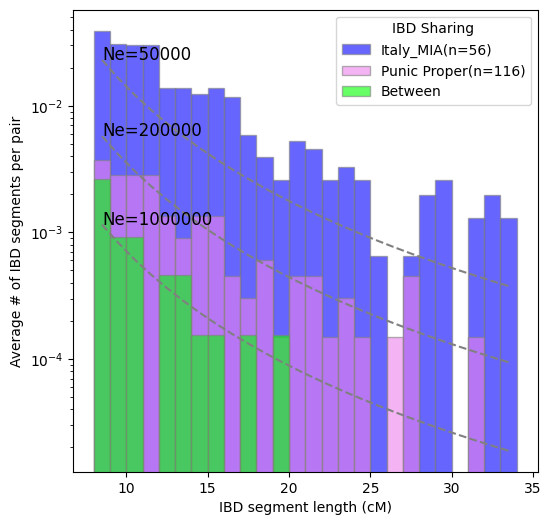

In [23]:
label1 = "Italy_MIA"
iids1 = df_meta[df_meta["clst"]==label1]["Master ID"].values

iids2 = df_pp["iid"].values

n1,n2 = len(iids1), len(iids2)
print(f"Found {n1} for {label1}.")
print(f"Found {n2} for Punic Proper.")

plot_ibd_2sites(
    df_ibd=df_ibd, df_ibd_ind=df_ibd_ind, df_meta=df_meta,
    iids1=iids1, iids2=iids2, site1=label1 + f"(n={n1})", site2="Punic Proper" + f"(n={n2})",
    figsize = (6,6),
    bins = np.arange(8, 35, 1),
    Ne_plot = [50000, 200000, 1000000], # Diploid Pop Size
    yscale="log",
    savepath = "")